In [1]:
data_dir = 'data/'
code_dir = '../../../reference-matching-evaluation'
img_dir = 'images/'

In [2]:
import sys
sys.path.append(code_dir)

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy.stats as st
import seaborn as sns
import utils.data_format_keys as dfk

from matplotlib.lines import Line2D
from scipy.stats import norm
from statistics import mean, stdev
from statsmodels.stats.proportion import proportion_confint
from utils.utils import read_json

In [3]:
dataset = []
for i in range(11):
    dataset.extend(read_json(data_dir + 'sbm-matched' + str(i) + '.json.zip')[dfk.DATASET_DATASET])
len(dataset)

1000000

In [4]:
def to_sample(dataset):
    return [1 if d['target_gt']['DOI'] == d['target_test']['DOI'] else 0 for d in dataset]

def get_average(dataset):
    return mean(to_sample(dataset))

get_average(dataset)

0.933005

In [5]:
def confidence_interval(sample, confidence_level):
    return proportion_confint(len([s for s in sample if s == 1]), len(sample), alpha=1-confidence_level)

random.seed(1001)
sample_100 = to_sample(random.sample(dataset, 100))
print(mean(sample_100))
print(confidence_interval(sample_100, .95))

random.seed(1001)
sample_1000 = to_sample(random.sample(dataset, 1000))
print(mean(sample_1000))
print(confidence_interval(sample_1000, .95))

0.92
(0.8668275100072333, 0.9731724899927667)
0.932
(0.9163969139520315, 0.9476030860479686)


([0.9282828282828283], [(0.9122103728872822, 0.9443552836783743)])

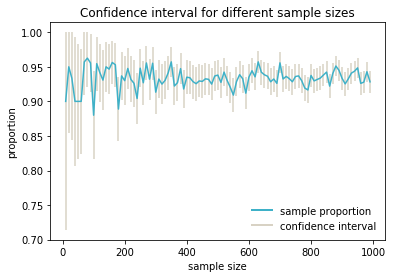

In [6]:
x = np.arange(0, 1000, 10)[1:]
random.seed(1001)
samples = [random.sample(dataset, size) for size in x]
y = [get_average(s) for s in samples]
cis = [confidence_interval(to_sample(s), .95) for s in samples]
se = [[a-ci[0] for ci, a in zip(cis, y)], [ci[1]-a for ci, a in zip(cis, y)]]
fig, ax = plt.subplots()
plt.errorbar(x, y, yerr=se, color='#3eb1c8', ecolor='#d8d2c4')
ax.legend([Line2D([0], [0], color='#3eb1c8', lw=2),
           Line2D([0], [0], color='#d8d2c4', lw=2)],
          ['sample proportion', 'confidence interval'], frameon=False, loc=4)
plt.xlabel('sample size')
plt.ylabel('proportion')
plt.title('Confidence interval for different sample sizes')
plt.savefig(img_dir + 'ci_by_size.png', dpi=300, bbox_inches='tight')
y[-1:], cis[-1:]

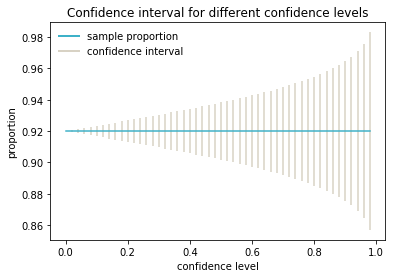

In [7]:
x = np.arange(0, 1, .02)
y = [mean(sample_100)] * len(x)
cis = [confidence_interval(sample_100, cl) for cl in x]
se = [[a-ci[0] for ci, a in zip(cis, y)], [ci[1]-a for ci, a in zip(cis, y)]]
fig, ax = plt.subplots()
plt.errorbar(x, y, yerr=se, color='#3eb1c8', ecolor='#d8d2c4')
ax.legend([Line2D([0], [0], color='#3eb1c8', lw=2),
           Line2D([0], [0], color='#d8d2c4', lw=2)],
          ['sample proportion', 'confidence interval'], loc=2, frameon=False)
plt.xlabel('confidence level')
plt.ylabel('proportion')
plt.title('Confidence interval for different confidence levels')
plt.savefig(img_dir + 'ci_by_cl.png', dpi=300, bbox_inches='tight')

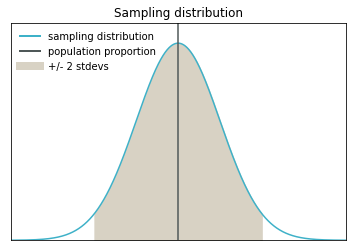

In [8]:
x_axis = np.arange(-4, 4, 0.001)
fig, ax = plt.subplots()
plt.plot(x_axis, norm.pdf(x_axis, 0, 1), color='#3eb1c8')
plt.xticks([], [])
plt.yticks([], [])
plt.axvline(x=0, color='#4f5858')
plt.fill_between(np.arange(-2, 2, 0.001), 0, norm.pdf(np.arange(-2, 2, 0.001), 0, 1), color='#d8d2c4')
plt.xlim(-4, 4)
plt.ylim(0, 0.44)
ax.legend([Line2D([0], [0], color='#3eb1c8', lw=2),
           Line2D([0], [0], color='#4f5858', lw=2),
           Line2D([0], [0], color='#d8d2c4', lw=8)],
          ['sampling distribution', 'population proportion', '+/- 2 stdevs'], loc=2, frameon=False)
plt.title('Sampling distribution')
plt.savefig(img_dir + 'sampling_distribution.png', dpi=300, bbox_inches='tight')

In [9]:
sizes = [25, 50, 100, 200, 400, 800, 1600, 3200]
l = len(sizes)
sampling_means = {s: {} for s in sizes}
intervals = {s: {} for s in sizes}
means = pd.DataFrame(np.zeros((l, l)), index=sizes, columns=sizes)
stdevs = pd.DataFrame(np.zeros((l, l)), index=sizes, columns=sizes)
contains_real = pd.DataFrame(np.zeros((l, l)), index=sizes, columns=sizes)

In [10]:
i = 0
for sample_size in sizes:
    for samples in sizes:
        i = i+1
        random.seed(i*sample_size*samples)
        print('{} samples of size {} each'.format(samples, sample_size))
        distribution = [random.sample(dataset, sample_size) for i in range(samples)]
        distribution = [to_sample(d) for d in distribution]
        sampling_means[sample_size][samples] = [mean(d) for d in distribution]
        intervals[sample_size][samples] = [confidence_interval(d, .95) for d in distribution]
        means.at[sample_size, samples] = mean(sampling_means[sample_size][samples])
        stdevs.at[sample_size, samples] = stdev(sampling_means[sample_size][samples])
        contains_real.at[sample_size, samples] = \
            len([i for i in intervals[sample_size][samples] if 0.933005>=i[0] and 0.933005<=i[1]])/ \
            len(intervals[sample_size][samples])

25 samples of size 25 each
50 samples of size 25 each
100 samples of size 25 each
200 samples of size 25 each
400 samples of size 25 each
800 samples of size 25 each
1600 samples of size 25 each
3200 samples of size 25 each
25 samples of size 50 each
50 samples of size 50 each
100 samples of size 50 each
200 samples of size 50 each
400 samples of size 50 each
800 samples of size 50 each
1600 samples of size 50 each
3200 samples of size 50 each
25 samples of size 100 each
50 samples of size 100 each
100 samples of size 100 each
200 samples of size 100 each
400 samples of size 100 each
800 samples of size 100 each
1600 samples of size 100 each
3200 samples of size 100 each
25 samples of size 200 each
50 samples of size 200 each
100 samples of size 200 each
200 samples of size 200 each
400 samples of size 200 each
800 samples of size 200 each
1600 samples of size 200 each
3200 samples of size 200 each
25 samples of size 400 each
50 samples of size 400 each
100 samples of size 400 each
200

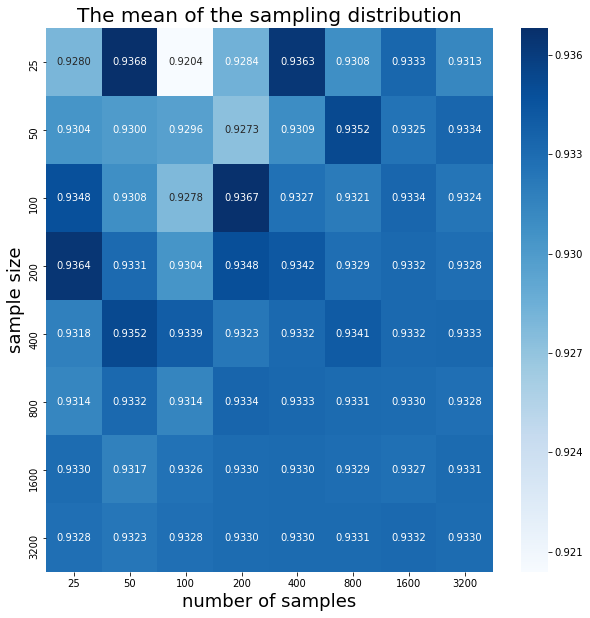

In [11]:
means
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(means, annot=True, fmt='.4f', xticklabels=sizes, yticklabels=sizes, cmap="Blues")
plt.ylabel('sample size', fontsize=18)
plt.xlabel('number of samples', fontsize=18)
plt.title('The mean of the sampling distribution', fontsize=20)
plt.savefig(img_dir + 'sampling_means.png', dpi=300, bbox_inches='tight')

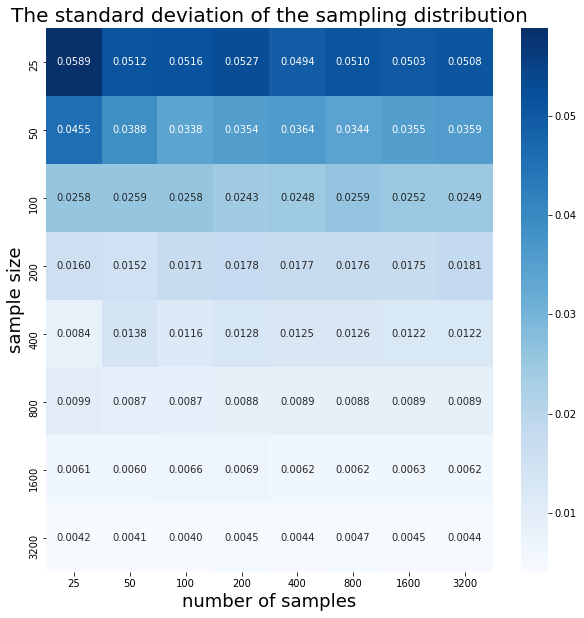

In [12]:
stdevs
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(stdevs, annot=True, fmt='.4f', xticklabels=sizes, yticklabels=sizes, cmap="Blues")
plt.ylabel('sample size', fontsize=18)
plt.xlabel('number of samples', fontsize=18)
plt.title('The standard deviation of the sampling distribution', fontsize=20)
plt.savefig(img_dir + 'sampling_stdevs.png', dpi=300, bbox_inches='tight')

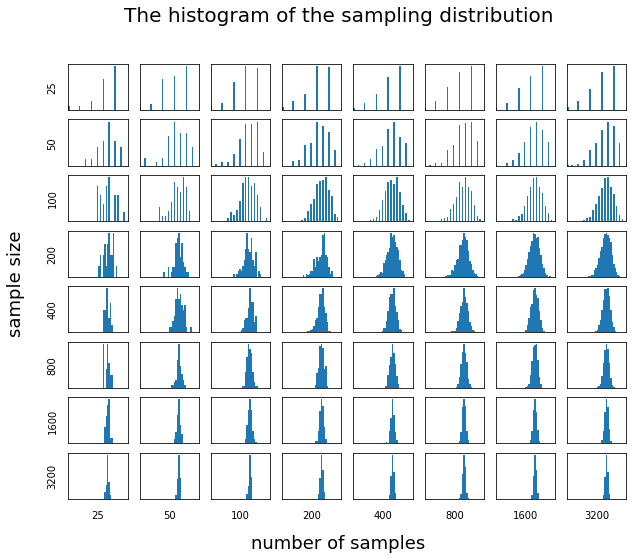

In [13]:
f, axes = plt.subplots(8, 8, sharex=True, figsize=(10, 8))
for i in range(8):
    for j in range(8):
        axes[i, j].hist(sampling_means[sizes[i]][sizes[j]], bins=np.arange(0.8, 1, 0.005))
        axes[i, j].xaxis.set_ticks_position('none')
        axes[i, j].yaxis.set_ticks_position('none')
        axes[i, j].set_xticklabels([])
        axes[i, j].set_yticklabels([])
        axes[i, j].set_xlim(0.8, 1)
for i in range(8):
    axes[i, 0].set(ylabel=sizes[i])
for i in range(8):
    axes[7, i].set(xlabel=sizes[i])
f.suptitle('The histogram of the sampling distribution', fontsize=20)
f.text(0.5, 0.04, 'number of samples', ha='center', fontsize=18)
f.text(0.04, 0.5, 'sample size', va='center', rotation='vertical', fontsize=18)
plt.savefig(img_dir + 'sampling_histograms.png', dpi=300, bbox_inches='tight')

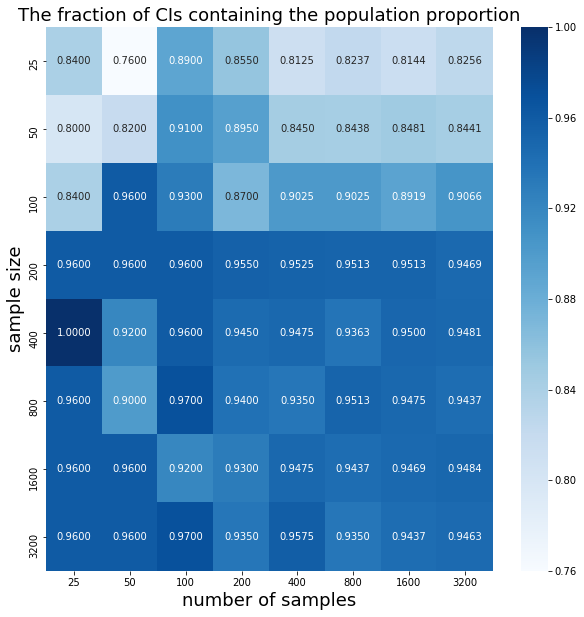

In [14]:
means
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(contains_real, annot=True, fmt='.4f', xticklabels=sizes, yticklabels=sizes, cmap="Blues")
plt.ylabel('sample size', fontsize=18)
plt.xlabel('number of samples', fontsize=18)
plt.title('The fraction of CIs containing the population proportion', fontsize=18)
plt.savefig(img_dir + 'sampling_fractions.png', dpi=300, bbox_inches='tight')